In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
def change_marital_status(status):
    if status == 0:
        return 'Divorced'
    elif status == 1:
        return 'Single'
    elif status == 2:
        return 'Married'
    elif status == 3:
        return 'Widowed'
    else:
        return 'Unknown'

# Read Data

In [3]:
df = pd.read_csv('medicalmalpractice.csv')

# replace whitespace
df.columns = df.columns.str.replace(' ', '')

# Let's replace Matital Status values with their Actual Values
df.MaritalStatus = df.MaritalStatus.apply(lambda status: change_marital_status(status))

df.head()

,Amount,Severity,Age,PrivateAttorney,MaritalStatus,Specialty,Insurance,Gender
0,57041,7,62,1,Married,Family Practice,Private,Male
1,324976,6,38,1,Married,OBGYN,No Insurance,Female
2,135383,4,34,1,Married,Cardiology,Unknown,Male
3,829742,7,42,1,Single,Pediatrics,No Insurance,Female
4,197675,3,60,0,Married,OBGYN,Medicare/Medicaid,Female


In [4]:
df.describe()

,Amount,Severity,Age,PrivateAttorney
count,79210.000000,79210.000000,79210.000000,79210.000000
mean,157484.554816,4.799659,42.701868,0.660889
std,193135.093293,2.083439,19.811063,0.473411
min,1576.000000,1.000000,0.000000,0.000000
25%,43670.250000,3.000000,28.000000,0.000000
50%,98131.000000,4.000000,43.000000,1.000000
75%,154675.250000,7.000000,58.000000,1.000000
max,926411.000000,9.000000,87.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79210 entries, 0 to 79209
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Amount           79210 non-null  int64 
 1   Severity         79210 non-null  int64 
 2   Age              79210 non-null  int64 
 3   PrivateAttorney  79210 non-null  int64 
 4   MaritalStatus    79210 non-null  object
 5   Specialty        79210 non-null  object
 6   Insurance        79210 non-null  object
 7   Gender           79210 non-null  object
dtypes: int64(4), object(4)
memory usage: 4.8+ MB


In [6]:
df.isna().sum()

Amount             0
Severity           0
Age                0
PrivateAttorney    0
MaritalStatus      0
Specialty          0
Insurance          0
Gender             0
dtype: int64

Let's start by exploring the differences in Categorical Variables.  We will explore what effect Marital Status, Specialty, Insurance, and Gender have on the settlement amount.

# Categorical Variable Exploration

In [7]:
df.groupby('MaritalStatus').aggregate({'Amount': 'mean', 'Severity': 'mean', 
                                                       'PrivateAttorney': 'mean', 'MaritalStatus': 'count'})

,Amount,Severity,PrivateAttorney,MaritalStatus
MaritalStatus,,,,
Divorced,371608.095511,6.032359,0.792015,3832
Married,154065.645221,4.879185,0.709656,41220
Single,156064.222787,4.670599,0.633278,22802
Unknown,100658.336904,4.307663,0.446632,10362
Widowed,98757.921529,4.839034,1.000000,994


In [8]:
# same thing, different way for fun
df.pivot_table(values = ['Amount', 'Severity', 'PrivateAttorney'], columns = 'MaritalStatus', aggfunc = 'mean')

MaritalStatus,Divorced,Married,Single,Unknown,Widowed
Amount,371608.095511,154065.645221,156064.222787,100658.336904,98757.921529
PrivateAttorney,0.792015,0.709656,0.633278,0.446632,1.000000
Severity,6.032359,4.879185,4.670599,4.307663,4.839034


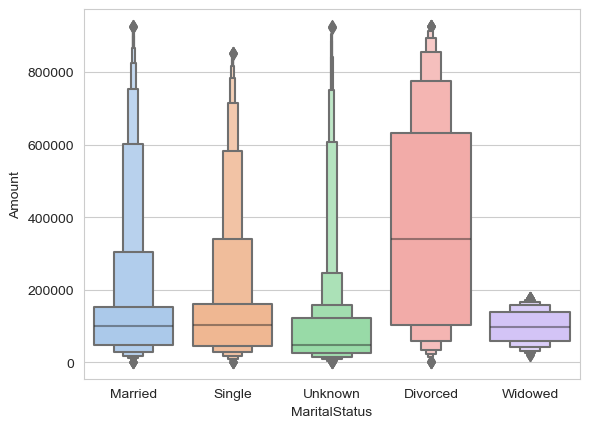

In [9]:
sns.boxenplot(data = df, x = 'MaritalStatus', y = 'Amount')
plt.show()

In [10]:
import scipy.stats as stats
fvalue, pvalue = stats.f_oneway(df[df.MaritalStatus == 'Married'].Amount,
                                df[df.MaritalStatus == 'Divorced'].Amount,
                                df[df.MaritalStatus == 'Single'].Amount,
                                df[df.MaritalStatus == 'Widowed'].Amount,
                                df[df.MaritalStatus == 'Unknown'].Amount)

print("fvalue:", fvalue)
print("pvalue:", pvalue)

fvalue: 1539.259396020193
pvalue: 0.0


Based on the p-value above for the differences between the Marital Status groups, we will include this field as a variable in our model!

In [11]:
specialty_group = df.groupby('Specialty').aggregate({'Amount': 'mean', 'Severity': 'mean', 'Specialty': 'count'})
specialty_group

,Amount,Severity,Specialty
Specialty,,,
Anesthesiology,60398.849634,3.771415,8732
Cardiology,94159.338473,4.924408,2659
Dermatology,354753.329480,5.726156,1384
Emergency Medicine,145732.356929,4.670231,4676
Family Practice,213266.389035,5.272823,11436
General Surgery,132403.394496,4.845623,9412
Internal Medicine,143943.532644,4.600996,5223
Neurology/Neurosurgery,241276.952713,5.605446,4737
OBGYN,219075.251352,4.883168,8876


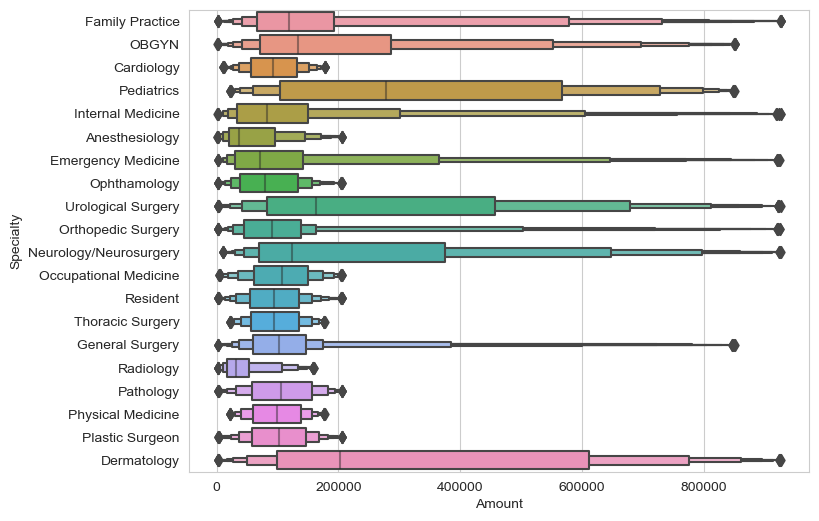

In [12]:
plt.figure(figsize=(8,6))
sns.boxenplot(data = df, x = 'Amount', y='Specialty')
plt.show()

There are a few groups who have a higher than average median, but for the most part the difference in Amount among Specialties does not seem to be significant.  Among the specialties with higher than average claims, these specialties also tend to have a higher severity, indicating that the severity of the Claim is more than likely what's driving up the Claims for these specialties.

In [13]:
df.groupby('Insurance').aggregate({'Amount': 'mean', 'Severity': 'mean', 'Insurance': 'count'})

,Amount,Severity,Insurance
Insurance,,,
Medicare/Medicaid,85152.680482,4.448906,10882
No Insurance,133026.672707,4.506873,8002
Private,226913.144128,5.153139,34289
Unknown,104550.150091,4.541202,24052
Workers Compensation,94698.072544,4.928463,1985


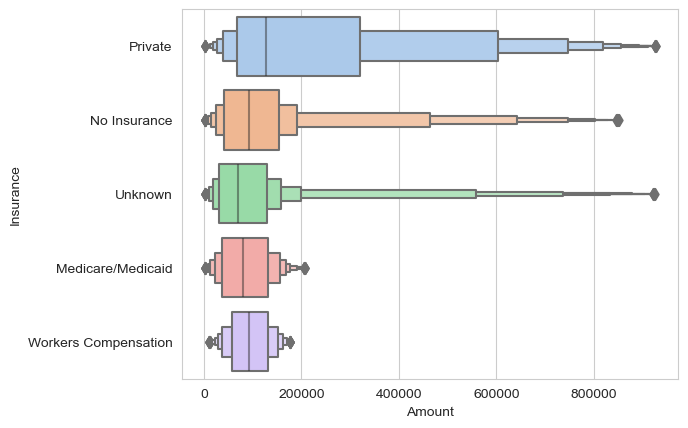

In [14]:
sns.boxenplot(data = df, x = 'Amount', y = 'Insurance')
plt.show()

In [15]:
fvalue, pvalue = stats.f_oneway(df[df.Insurance == 'Private'].Amount,
                                df[df.Insurance == 'No Insurance'].Amount,
                                df[df.Insurance == 'Unknown'].Amount,
                                df[df.Insurance == 'Medicare/Medicaid'].Amount,
                                df[df.Insurance == 'Workers Compensation'].Amount)

print("fvalue:", fvalue)
print("pvalue:", pvalue)

fvalue: 2256.2612421786316
pvalue: 0.0


The p-value is again indicating that there is a significant difference between the population mean of these groups, so we will include this variable in our model.

In [16]:
df.groupby('Gender').mean()

,Amount,Severity,Age,PrivateAttorney
Gender,,,,
Female,150957.808290,4.752188,39.167448,0.660477
Male,167401.306775,4.871788,48.072074,0.661514


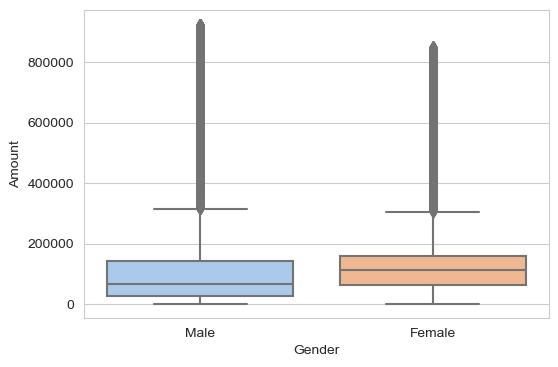

In [17]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df, x = 'Gender', y = 'Amount')
plt.show()

In [18]:
df.groupby('PrivateAttorney').mean()

,Amount,Severity,Age
PrivateAttorney,,,
0,86869.740516,3.934291,45.329772
1,193717.998185,5.243691,41.353455


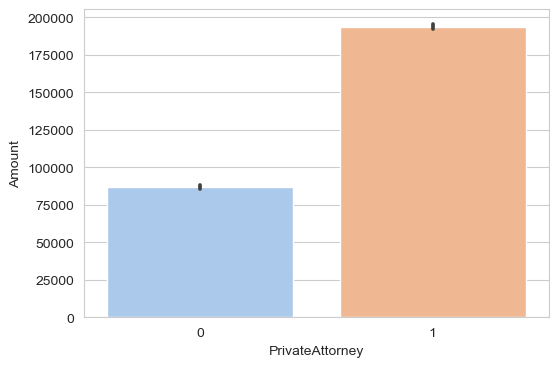

In [19]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'PrivateAttorney', y = 'Amount')
plt.show()

There is a significant different in the amount of money someone get's from a claim depending on whether or not they are represented by a private attorney.  

# Discrete Variable Exploration

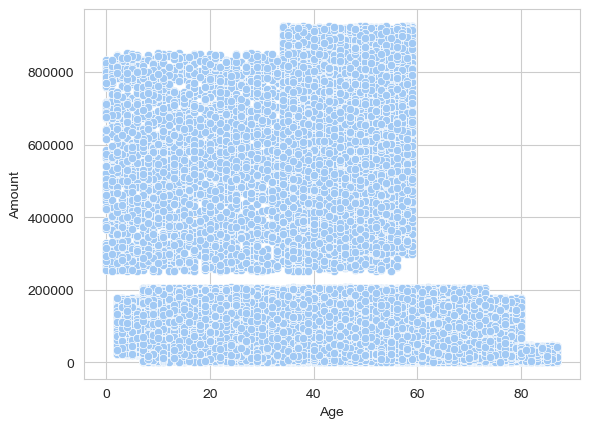

In [20]:
sns.scatterplot(data = df, x = 'Age', y = 'Amount')
plt.show()

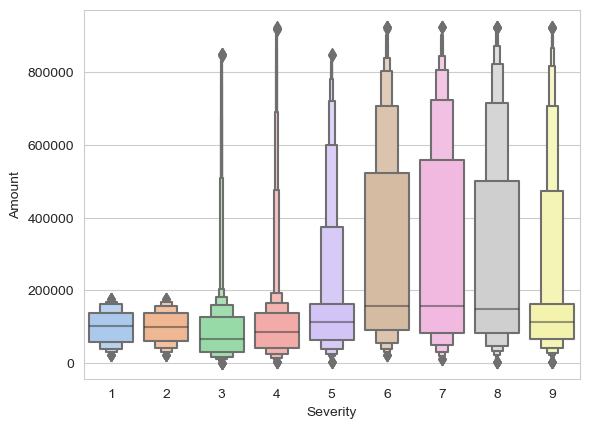

In [21]:
sns.boxenplot(data = df, x = 'Severity', y = 'Amount')
plt.show()

We can see a clear correlation here between the amount of a claim and it's severity.  More severe claims tend to have higher payouts.

# Feature Consideration

Given the feature analysis done above, we will select the variables that seem to have a significant correlation with the amount of the claim.  Based on the analysis, let's use the following variables for out machine learning model.

> 1. Severity
> 2. Private Attorney
> 3. Insurance
> 4. Marital Status

# Pipeline

### Num Pipeline

In [22]:
df[['Severity']]

,Severity
0,7
1,6
2,4
3,7
4,3
...,...
79205,4
79206,3
79207,3
79208,9


In [23]:
num_df = df[['Severity']]

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

num_tr = num_pipeline.fit_transform(num_df)
num_tr[0:5]

array([[ 1.05611694],
       [ 0.57613815],
       [-0.38381942],
       [ 1.05611694],
       [-0.86379821]])

In [24]:
one_hot = OneHotEncoder()
one_hot.fit_transform(df[['PrivateAttorney', 'MaritalStatus', 'Insurance']])

one_hot.get_feature_names_out(['PrivateAttorney', 'MaritalStatus', 'Insurance'])

array(['PrivateAttorney_0', 'PrivateAttorney_1', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       'MaritalStatus_Unknown', 'MaritalStatus_Widowed',
       'Insurance_Medicare/Medicaid', 'Insurance_No Insurance',
       'Insurance_Private', 'Insurance_Unknown',
       'Insurance_Workers Compensation'], dtype=object)

### Cat Pipeline

In [25]:
cat_df = df[['PrivateAttorney', 'MaritalStatus', 'Insurance']]

cat_pipeline = Pipeline([
    ('One Hot', OneHotEncoder())
])

cat_tr = cat_pipeline.fit_transform(cat_df)
cat_tr_array = cat_tr.toarray()
cat_tr_array

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

### Full Pipeline

In [26]:
num_attribs = ['Severity']
cat_attribs = ['PrivateAttorney', 'MaritalStatus', 'Insurance']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

df_prepared = full_pipeline.fit_transform(df)
df_prepared

array([[ 1.05611694,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.57613815,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38381942,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.86379821,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 2.01607452,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.05611694,  0.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ]])

In [27]:
df_prepared.shape

(79210, 13)

In [28]:
full_pipeline.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Severity']),
                                ('cat',
                                 Pipeline(steps=[('One Hot', OneHotEncoder())]),
                                 ['PrivateAttorney', 'MaritalStatus',
                                  'Insurance'])])>

# Modeling

In [29]:
X = df_prepared
y = df['Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

In [30]:
rf = RandomForestRegressor(n_estimators = 300, min_samples_split = 10, max_depth = 5)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=300)

In [31]:
predictions = rf.predict(X_test)

average_error = mean_absolute_error(y_test, predictions) # compare predictions with our test set
print("Average Prediction Error:", average_error)

Average Prediction Error: 98268.94015544243
